In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


2.6.0+cu118
11.8
90100


In [2]:
!pip install medmnist
!pip install torchinfo
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No GPU found"

print(f"CUDA Available: {cuda_available}")
print(f"GPU: {gpu_name}")


CUDA Available: True
GPU: Tesla T4


In [4]:
import medmnist
from medmnist import OCTMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter
import torchinfo
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset
from torch.utils.data import Dataset

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
train_dataset = OCTMNIST(split='train', download=True)
val_dataset = OCTMNIST(split='val', download=True)
test_dataset = OCTMNIST(split='test', download=True)

images_train = train_dataset.imgs
labels_train = train_dataset.labels.flatten()
unique_train, counts_train = np.unique(labels_train, return_counts=True)
print("Dataset: Train")
print(f"Total samples: {len(images_train)}")
print(f"Image shape: {images_train[0].shape}")
print("Class distribution:")
for u, c in zip(unique_train, counts_train):
    print(f"  Class {u}: {c} samples")
print("-" * 30)

# Validation Dataset Analysis 
images_val = val_dataset.imgs
labels_val = val_dataset.labels.flatten()
unique_val, counts_val = np.unique(labels_val, return_counts=True)
print("Dataset: Validation")
print(f"Total samples: {len(images_val)}")
print(f"Image shape: {images_val[0].shape}")
print("Class distribution:")
for u, c in zip(unique_val, counts_val):
    print(f"  Class {u}: {c} samples")
print("-" * 30)

# Test Dataset Analysis
images_test = test_dataset.imgs
labels_test = test_dataset.labels.flatten()
unique_test, counts_test = np.unique(labels_test, return_counts=True)
print("Dataset: Test")
print(f"Total samples: {len(images_test)}")
print(f"Image shape: {images_test[0].shape}")
print("Class distribution:")
for u, c in zip(unique_test, counts_test):
    print(f"  Class {u}: {c} samples")
print("-" * 30)

Dataset: Train
Total samples: 97477
Image shape: (28, 28)
Class distribution:
  Class 0: 33484 samples
  Class 1: 10213 samples
  Class 2: 7754 samples
  Class 3: 46026 samples
------------------------------
Dataset: Validation
Total samples: 10832
Image shape: (28, 28)
Class distribution:
  Class 0: 3721 samples
  Class 1: 1135 samples
  Class 2: 862 samples
  Class 3: 5114 samples
------------------------------
Dataset: Test
Total samples: 1000
Image shape: (28, 28)
Class distribution:
  Class 0: 250 samples
  Class 1: 250 samples
  Class 2: 250 samples
  Class 3: 250 samples
------------------------------


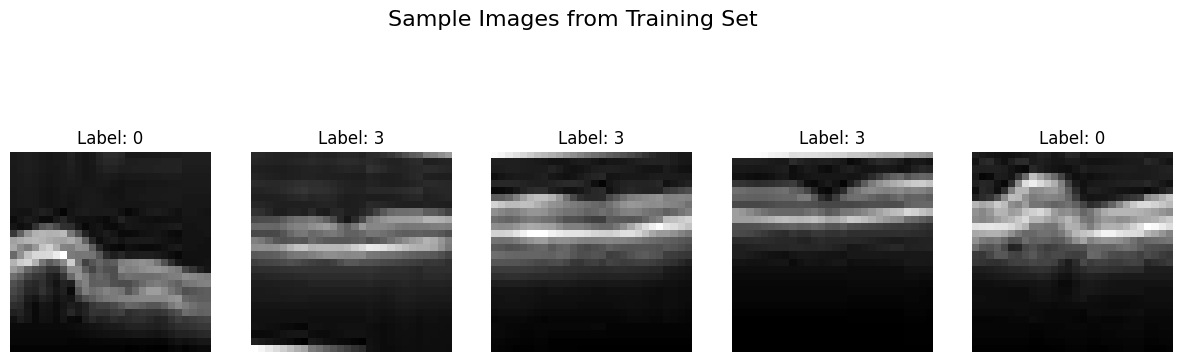

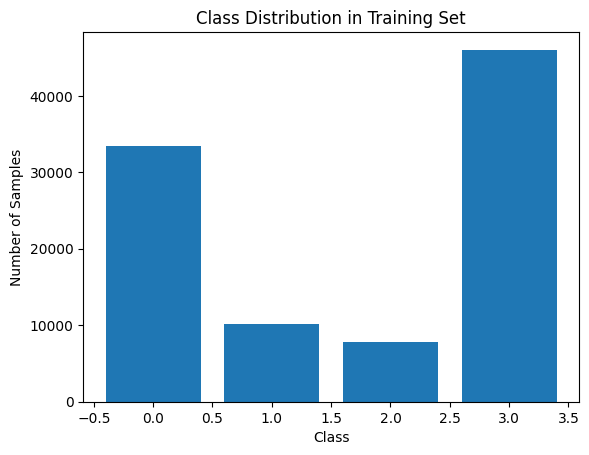

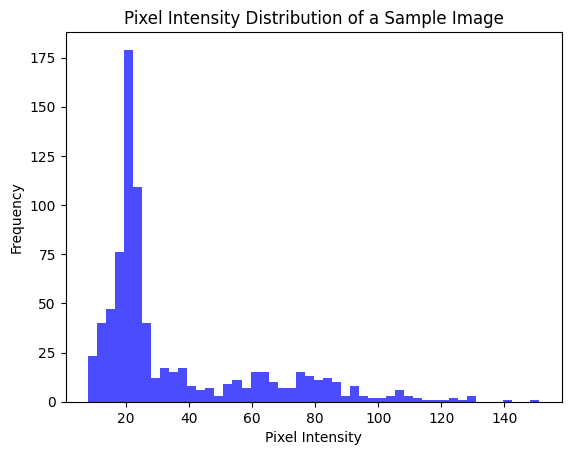

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(train_dataset.imgs[i], cmap='gray')
    axes[i].set_title(f"Label: {train_dataset.labels[i][0]}")
    axes[i].axis('off')
plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.show()

class_counts = Counter(labels_train)
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

sample_image = train_dataset.imgs[0]
plt.hist(sample_image.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution of a Sample Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

train_dataset = TransformedDataset(train_dataset, transform)
val_dataset = TransformedDataset(val_dataset, transform)
test_dataset = TransformedDataset(test_dataset, transform)

full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

total_size = len(full_dataset)
indices = np.arange(total_size)
np.random.shuffle(indices)

train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42) 

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print("Data preparation complete!")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Data preparation complete!
Training set size: 76516
Validation set size: 16396
Test set size: 16397


__BASE MODEL__

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

model = SimplerOCTMNIST_CNN()

from torchinfo import summary
summary(model, input_size=(1, 1, 112, 112))


Layer (type:depth-idx)                   Output Shape              Param #
SimplerOCTMNIST_CNN                      [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 112, 112]         320
├─MaxPool2d: 1-2                         [1, 32, 56, 56]           --
├─Conv2d: 1-3                            [1, 64, 56, 56]           18,496
├─MaxPool2d: 1-4                         [1, 64, 28, 28]           --
├─Linear: 1-5                            [1, 128]                  6,422,656
├─Dropout: 1-6                           [1, 128]                  --
├─Linear: 1-7                            [1, 64]                   8,256
├─Dropout: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 4]                    260
Total params: 6,449,988
Trainable params: 6,449,988
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 68.45
Input size (MB): 0.05
Forward/backward pass size (MB): 4.82
Params size (MB): 25.80
Estimate

In [ ]:
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


epochs = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time = time.time()
best_val_loss = float('inf')
best_val_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Starting Epoch {epoch+1}/{epochs}...")

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss_epoch = 0.0
    correct_val = 0
    total_val = 0

    print(f"Validating Epoch {epoch+1}...")

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_labels = val_labels.squeeze().long()
            val_outputs = model(val_inputs)
            val_loss_epoch += loss_function(val_outputs, val_labels).item()

            _, predicted = torch.max(val_outputs, 1)
            correct_val += (predicted == val_labels).sum().item()
            total_val += val_labels.size(0)

    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), 'base_model_part3.pth')

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.2f}%")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

cuda
Starting Epoch 1/5...
Epoch 1, Batch 0, Loss: 1.3737
Epoch 1, Batch 10, Loss: 1.2163
Epoch 1, Batch 20, Loss: 1.1818
Epoch 1, Batch 30, Loss: 1.2039
Epoch 1, Batch 40, Loss: 1.3011
Epoch 1, Batch 50, Loss: 1.3413
Epoch 1, Batch 60, Loss: 1.0810
Epoch 1, Batch 70, Loss: 1.1041
Epoch 1, Batch 80, Loss: 1.3191
Epoch 1, Batch 90, Loss: 1.1430
Epoch 1, Batch 100, Loss: 1.2925
Epoch 1, Batch 110, Loss: 1.2666
Epoch 1, Batch 120, Loss: 1.2400
Epoch 1, Batch 130, Loss: 1.1811
Epoch 1, Batch 140, Loss: 1.2407
Epoch 1, Batch 150, Loss: 1.2227
Epoch 1, Batch 160, Loss: 1.0651
Epoch 1, Batch 170, Loss: 1.1438
Epoch 1, Batch 180, Loss: 1.1109
Epoch 1, Batch 190, Loss: 1.0709
Epoch 1, Batch 200, Loss: 1.2003
Epoch 1, Batch 210, Loss: 1.2668
Epoch 1, Batch 220, Loss: 1.1132
Epoch 1, Batch 230, Loss: 1.0205
Epoch 1, Batch 240, Loss: 1.1271
Epoch 1, Batch 250, Loss: 1.1033
Epoch 1, Batch 260, Loss: 1.0684
Epoch 1, Batch 270, Loss: 0.9953
Epoch 1, Batch 280, Loss: 1.0981
Epoch 1, Batch 290, Loss: 1

In [ ]:
model.load_state_dict(torch.load('base_model_part3.pth'))
model.eval()
correct = 0
total = 0
predictions = []
true_labels = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_labels = test_labels.squeeze().long()

        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels)
        test_loss += loss.item()

        _, predicted = torch.max(test_outputs, 1)
        correct += (predicted == test_labels).sum().item()
        total += test_labels.size(0)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

accuracy = 100 * correct / total
test_loss /= len(test_loader)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


<ipython-input-12-80eab44adc84>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_part3.pth'))


Test Accuracy: 82.31%
Test Loss: 0.5014
Precision: 0.76, Recall: 0.82, F1 Score: 0.78


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(val_losses)
print(train_losses)
print(train_accuracies)
print(val_accuracies)

[0.7104020504867984, 0.6379918039772761, 0.563575226973003, 0.5489586902499662, 0.5267491345275701]
[0.8961099426832088, 0.6858329635898405, 0.6278434381088286, 0.5891069699589624, 0.5658059693922766]
[66.17439489779915, 76.22588739610016, 78.68027602070156, 79.92968790841131, 80.85237074598777]
[74.57916565015857, 77.61649182727494, 80.65381800439131, 80.54403513051965, 81.4344962185899]


Text(956.631313131313, 0.5, 'True')

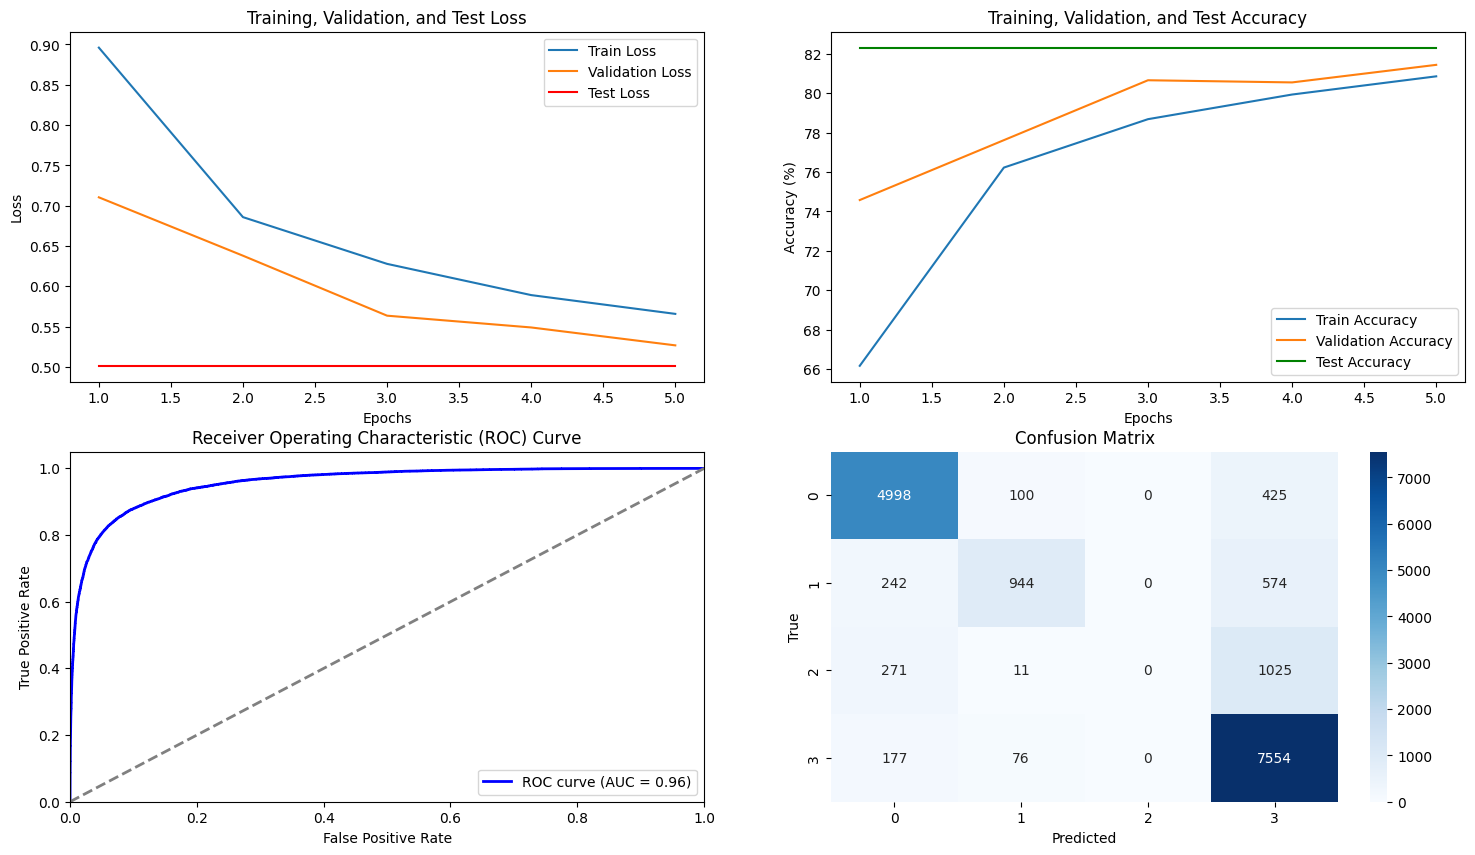

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import torch

all_true_labels = []
all_predictions_prob = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_labels = test_labels.squeeze().long()

        test_outputs = model(test_inputs)
        predictions_prob = torch.softmax(test_outputs, dim=1).cpu().numpy()

        all_true_labels.extend(test_labels.cpu().numpy())
        all_predictions_prob.extend(predictions_prob)

true_labels_bin = LabelBinarizer().fit_transform(all_true_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

test_loss_values = [test_loss] * epochs
test_accuracy_values = [accuracy] * epochs


plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs+1), test_loss_values, label='Test Loss', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs+1), test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.subplot(2, 2, 4)
import seaborn as sns
from sklearn.metrics import confusion_matrix

lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(all_true_labels)

cm = confusion_matrix(all_true_labels, np.argmax(predictions_prob, axis=1))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

__LOSS MODEL__

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
model = SimplerOCTMNIST_CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().long().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.squeeze().long().to(device)
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            correct_val += (predicted == val_labels).sum().item()
            total_val += val_labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), 'best_focal_model.pth')

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

print(f"Training completed in {time.time() - start_time:.2f} seconds.")

Epoch 1/5, Train Loss: 0.5453, Train Acc: 57.14%, Val Loss: 0.3763, Val Acc: 74.12%
Epoch 2/5, Train Loss: 0.3644, Train Acc: 75.70%, Val Loss: 0.3090, Val Acc: 78.00%
Epoch 3/5, Train Loss: 0.3208, Train Acc: 77.85%, Val Loss: 0.2762, Val Acc: 79.89%
Epoch 4/5, Train Loss: 0.2882, Train Acc: 79.75%, Val Loss: 0.2532, Val Acc: 80.93%
Epoch 5/5, Train Loss: 0.2682, Train Acc: 80.66%, Val Loss: 0.2410, Val Acc: 81.52%
Training completed in 300.22 seconds.


In [ ]:
model.load_state_dict(torch.load('best_focal_model.pth'))
model.eval()
correct, total, test_loss = 0, 0, 0.0
predictions, true_labels = [], []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.squeeze().long().to(device)
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels)
        test_loss += loss.item()
        _, predicted = torch.max(test_outputs, 1)
        correct += (predicted == test_labels).sum().item()
        total += test_labels.size(0)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

accuracy = 100 * correct / total
test_loss /= len(test_loader)
print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {test_loss:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


<ipython-input-22-9234c26ea22e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_focal_model.pth'))


Test Accuracy: 82.50%, Test Loss: 0.2308
Precision: 0.84, Recall: 0.83, F1 Score: 0.79


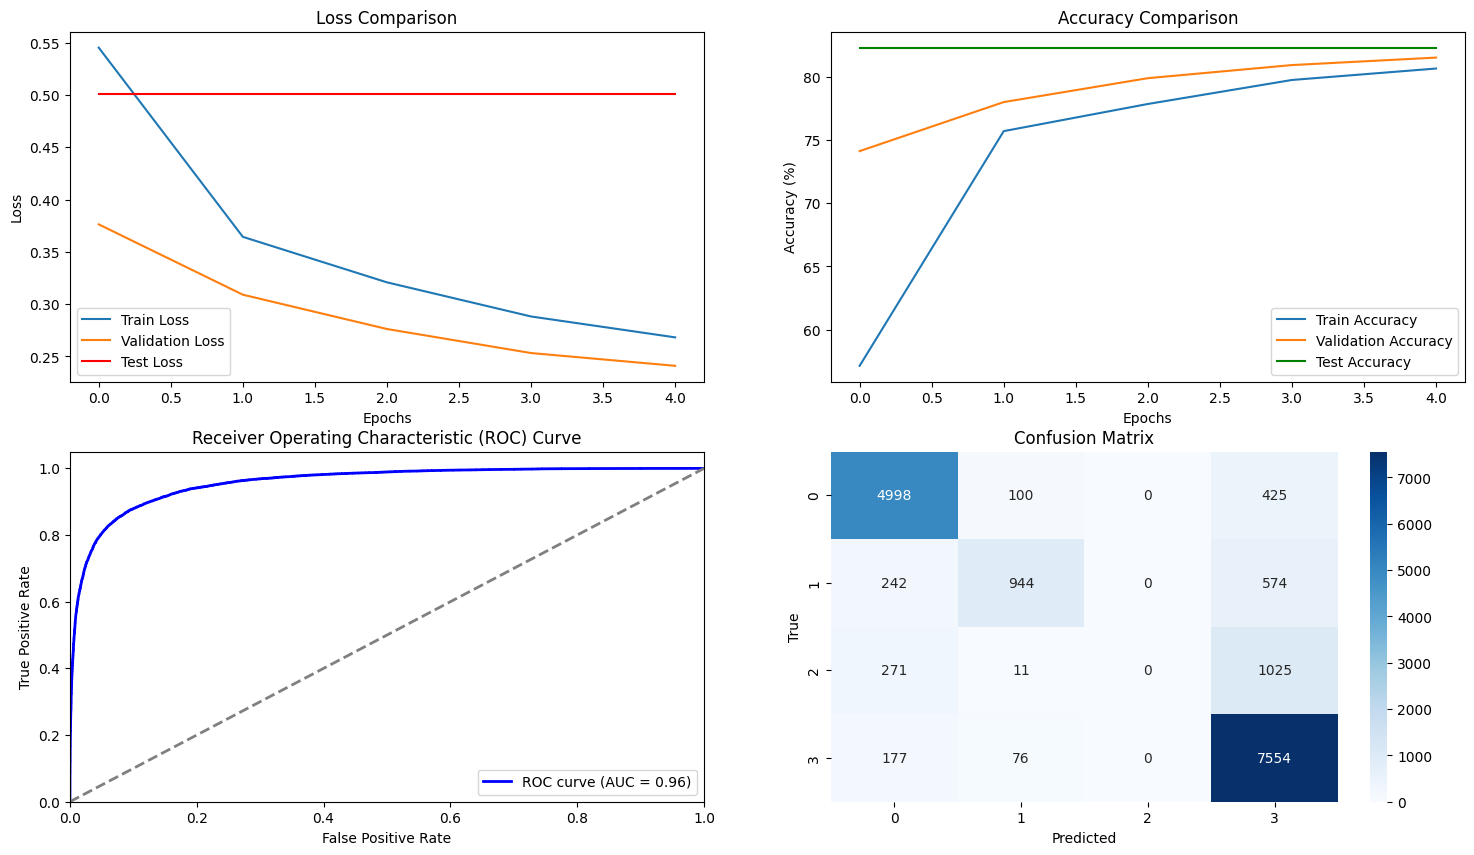

In [ ]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_loss_values, label='Test Loss', color='red')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.subplot(2, 2, 4)
cm = confusion_matrix(all_true_labels, np.argmax(predictions_prob, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

__EARLY STOPPING__

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [19]:
class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'best_model_weights_early_stopping.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1/5, Train Loss: 0.9447, Train Accuracy: 64.18%, Val Loss: 0.7269, Val Accuracy: 73.81%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.7529, Train Accuracy: 73.51%, Val Loss: 0.6896, Val Accuracy: 74.14%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.6623, Train Accuracy: 77.07%, Val Loss: 0.5158, Val Accuracy: 82.09%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.5858, Train Accuracy: 80.56%, Val Loss: 0.4747, Val Accuracy: 83.36%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.5471, Train Accuracy: 81.81%, Val Loss: 0.4665, Val Accuracy: 83.76%
Best model weights saved at epoch 5


In [ ]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.2f}%")

Test Loss : 0.4736
Test Accuracy : 83.56%


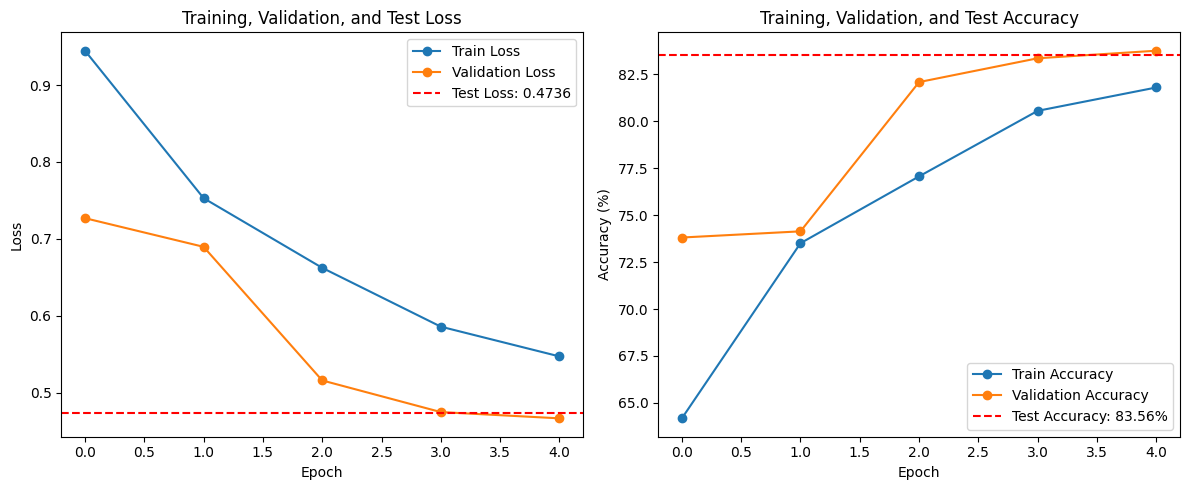

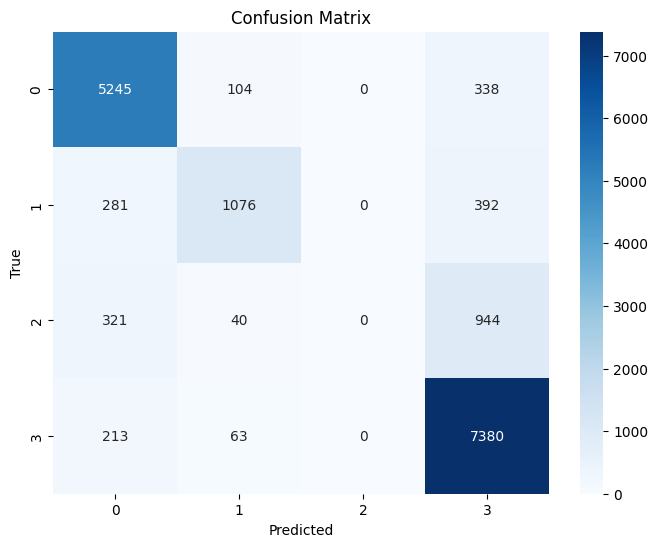

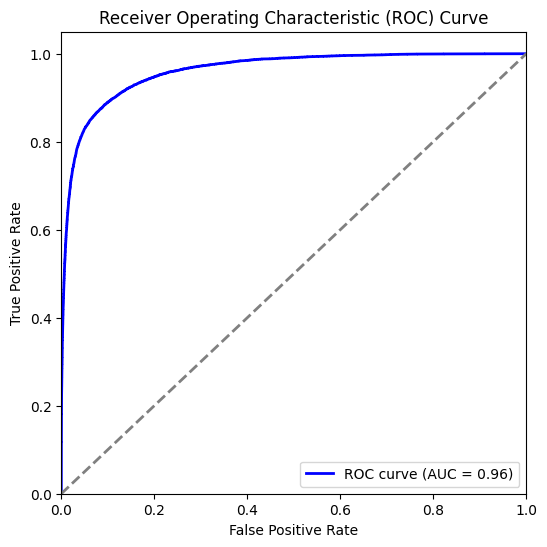

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}%')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

all_predictions_prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1) 
        all_predictions_prob.extend(probabilities.cpu().numpy())

true_labels_bin = LabelBinarizer().fit_transform(all_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


__Learning Rate Scheduler__

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'best_model_weights_learning_rate.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.8790, Train Accuracy: 67.20%, Val Loss: 0.7045, Val Accuracy: 74.57%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.6463, Train Accuracy: 77.97%, Val Loss: 0.5609, Val Accuracy: 80.55%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.5452, Train Accuracy: 81.87%, Val Loss: 0.4842, Val Accuracy: 83.36%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.5037, Train Accuracy: 83.24%, Val Loss: 0.4685, Val Accuracy: 83.50%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.4755, Train Accuracy: 84.02%, Val Loss: 0.4738, Val Accuracy: 83.23%


In [ ]:
model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss (Using Best Weights): {test_loss:.4f}")
print(f"Test Accuracy (Using Best Weights): {test_accuracy:.2f}%")

<ipython-input-32-01ce5ccab8d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded the best model weights for evaluation.
Test Loss (Using Best Weights): 0.4552
Test Accuracy (Using Best Weights): 84.11%


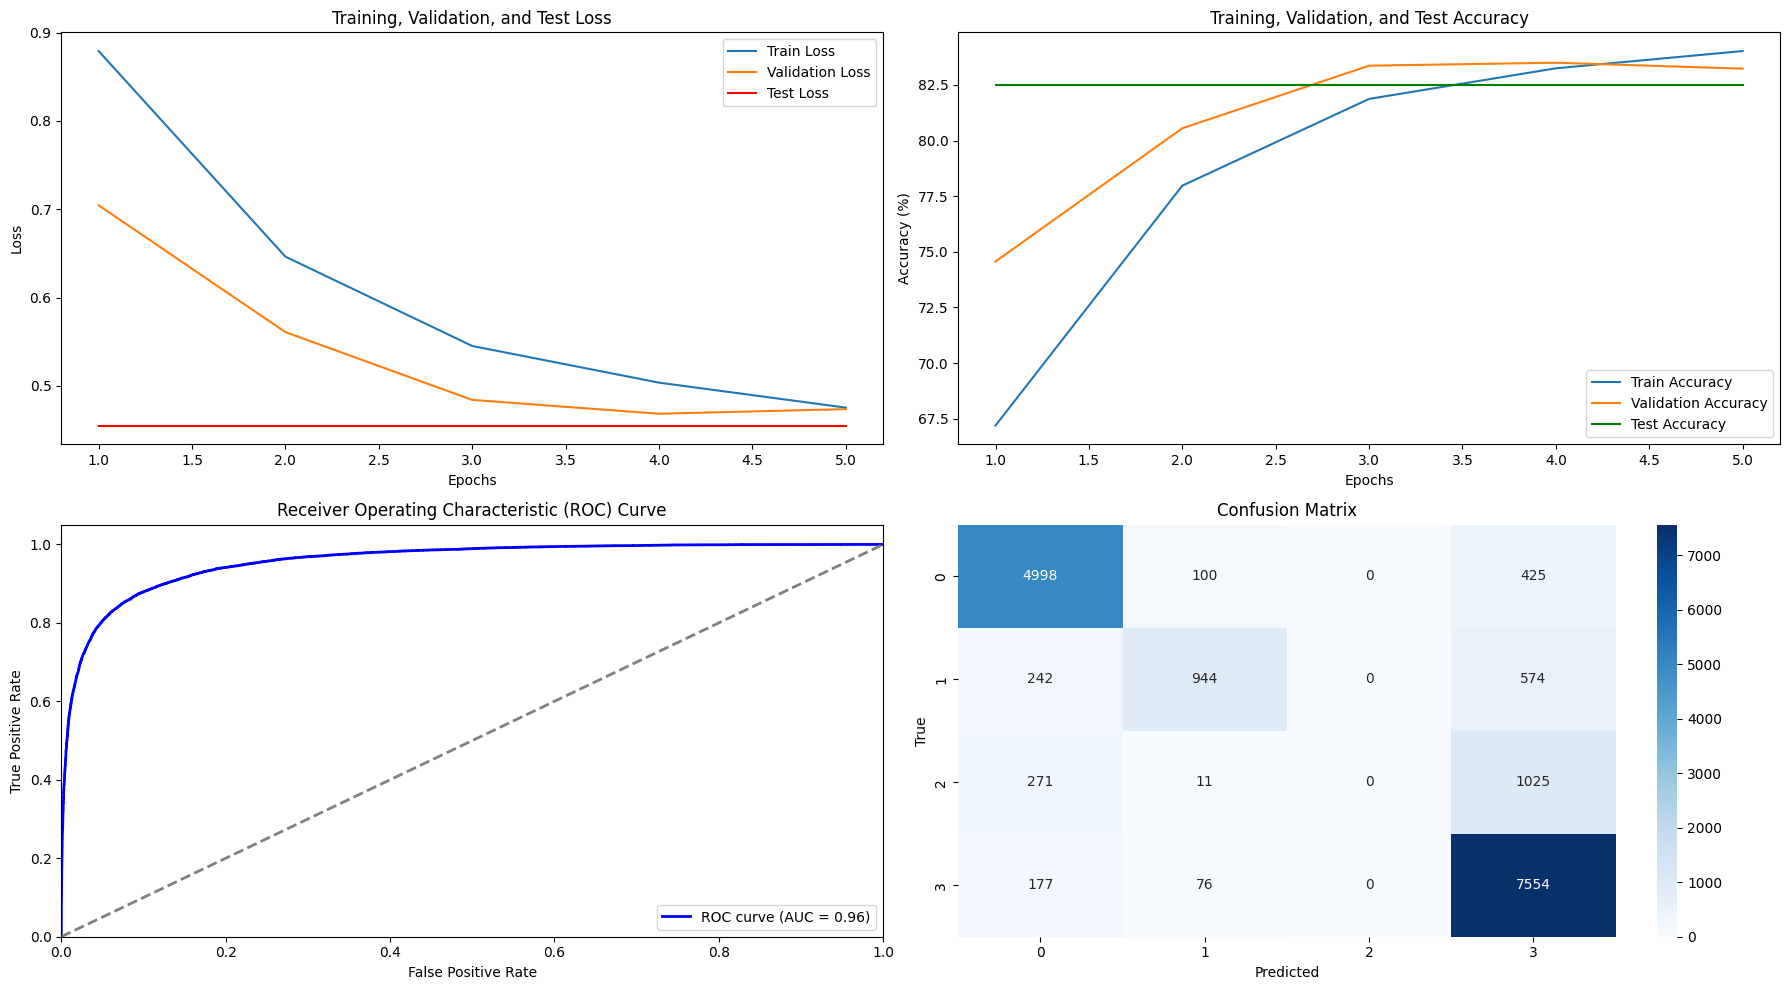

In [ ]:
test_loss_values = [test_loss] * epochs
test_accuracy_values = [accuracy] * epochs

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs + 1), test_loss_values, label='Test Loss', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

true_labels_bin = LabelBinarizer().fit_transform(all_true_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(all_true_labels)
cm = confusion_matrix(all_true_labels, np.argmax(predictions_prob, axis=1))

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


__Batch Normalization__

In [ ]:
class SimplerOCTMNIST_CNN_BN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN_BN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'best_model_weights_batch_normalization.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

Epoch 1/5, Train Loss: 0.6868, Train Accuracy: 76.04%, Val Loss: 0.7301, Val Accuracy: 74.66%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.5376, Train Accuracy: 81.94%, Val Loss: 0.6201, Val Accuracy: 77.01%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.5022, Train Accuracy: 83.05%, Val Loss: 0.5612, Val Accuracy: 80.19%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.4772, Train Accuracy: 83.75%, Val Loss: 0.4806, Val Accuracy: 82.78%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.4558, Train Accuracy: 84.41%, Val Loss: 0.6548, Val Accuracy: 75.96%
Loaded the best model weights for evaluation.


<ipython-input-35-bf3ed289f079>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss (using best weights): {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

<ipython-input-36-350b033590b1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded the best model weights for evaluation.
Test Loss (using best weights): 0.4614, Test Accuracy: 83.61%


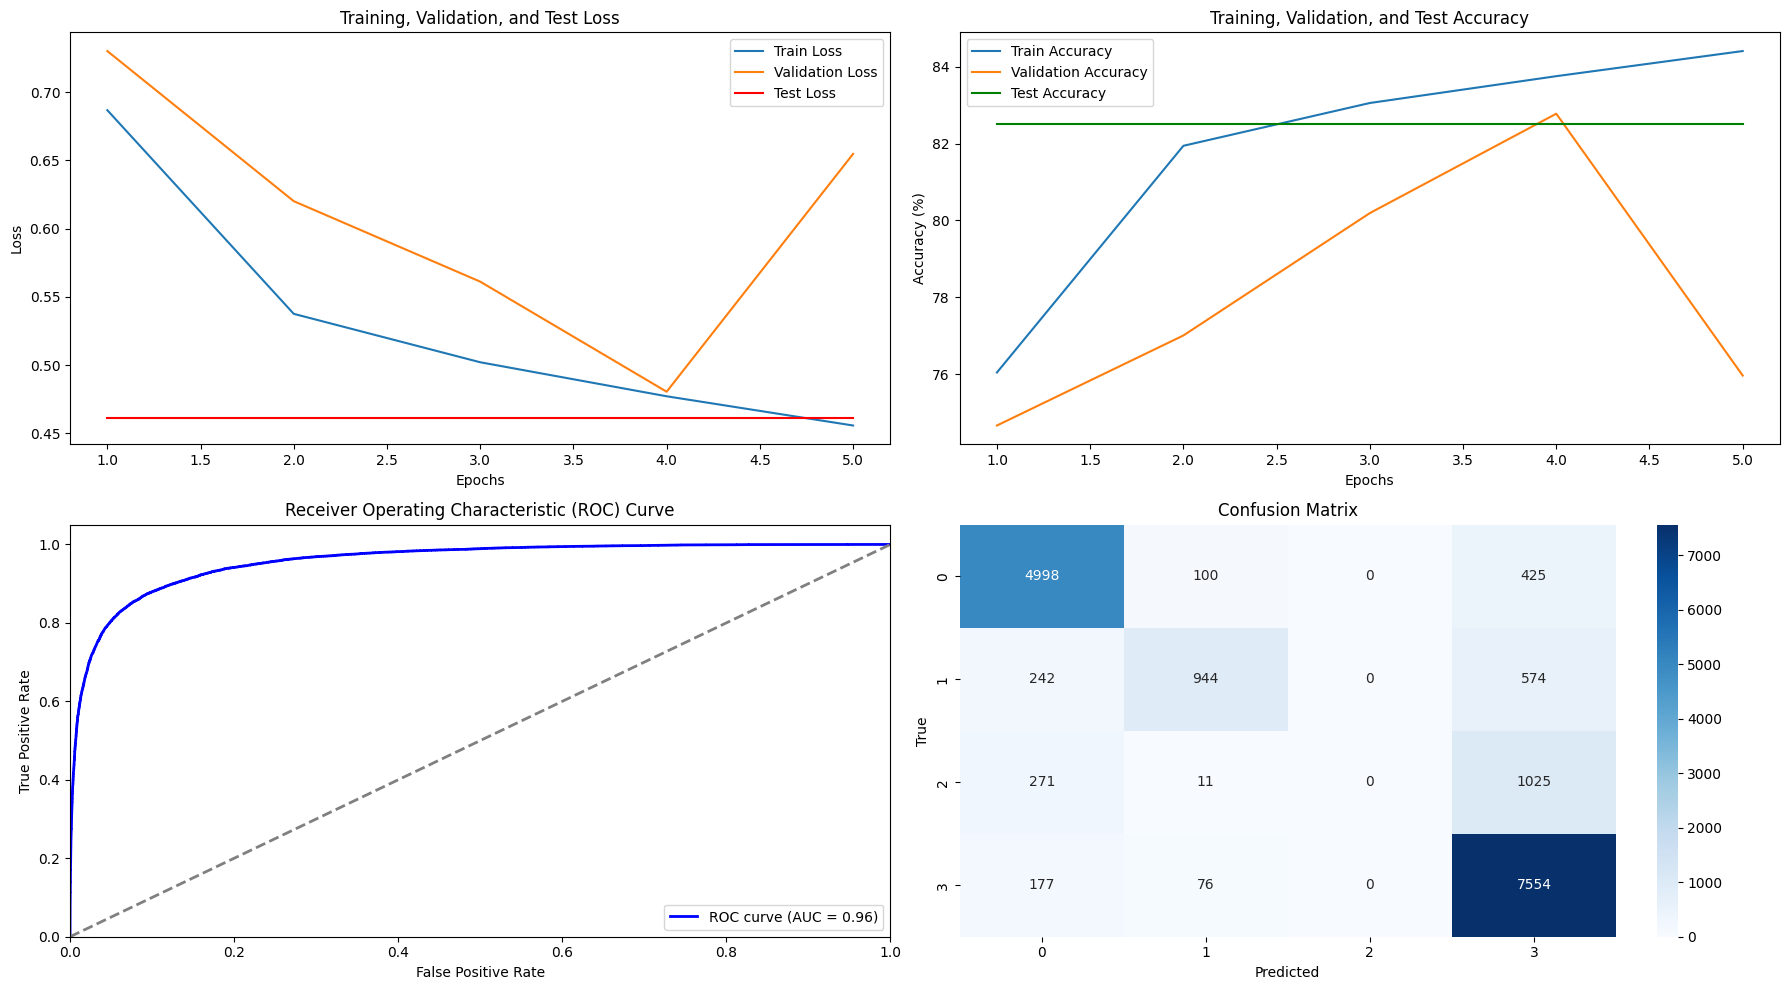

In [ ]:
test_loss_values = [test_loss] * epochs
test_accuracy_values = [accuracy] * epochs

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs + 1), test_loss_values, label='Test Loss', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

true_labels_bin = LabelBinarizer().fit_transform(all_true_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(all_true_labels)
cm = confusion_matrix(all_true_labels, np.argmax(predictions_prob, axis=1))

plt.subplot(2, 2, 4) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


__K-fold Cross-validation__

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

In [ ]:
class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.CrossEntropyLoss()

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

k_folds = 4
kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}
best_val_loss = float('inf')
best_model_path = 'best_model_weights_k_fold.pth'

for fold, (train_ids, val_ids) in enumerate(kfold.split(combined_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(combined_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = DataLoader(combined_dataset, batch_size=64, sampler=val_subsampler)

    model = SimplerOCTMNIST_CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    epochs = 4
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.squeeze().long()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model weights saved at fold {fold}, epoch {epoch+1}")

    results[fold] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

avg_train_losses = np.mean([results[fold]['train_losses'] for fold in range(k_folds)], axis=0)
avg_val_losses = np.mean([results[fold]['val_losses'] for fold in range(k_folds)], axis=0)
avg_train_accuracies = np.mean([results[fold]['train_accuracies'] for fold in range(k_folds)], axis=0)
avg_val_accuracies = np.mean([results[fold]['val_accuracies'] for fold in range(k_folds)], axis=0)

FOLD 0
--------------------------------
Epoch 1/4, Train Loss: 0.8867, Train Accuracy: 66.43%, Val Loss: 0.6841, Val Accuracy: 75.36%
Best model weights saved at fold 0, epoch 1
Epoch 2/4, Train Loss: 0.6896, Train Accuracy: 76.25%, Val Loss: 0.5777, Val Accuracy: 79.57%
Best model weights saved at fold 0, epoch 2
Epoch 3/4, Train Loss: 0.6171, Train Accuracy: 78.93%, Val Loss: 0.5264, Val Accuracy: 81.35%
Best model weights saved at fold 0, epoch 3
Epoch 4/4, Train Loss: 0.5713, Train Accuracy: 80.63%, Val Loss: 0.5307, Val Accuracy: 81.24%
FOLD 1
--------------------------------
Epoch 1/4, Train Loss: 0.8752, Train Accuracy: 67.50%, Val Loss: 0.7258, Val Accuracy: 74.54%
Epoch 2/4, Train Loss: 0.6585, Train Accuracy: 77.65%, Val Loss: 0.5860, Val Accuracy: 79.87%
Epoch 3/4, Train Loss: 0.5808, Train Accuracy: 80.55%, Val Loss: 0.4998, Val Accuracy: 82.84%
Best model weights saved at fold 1, epoch 3
Epoch 4/4, Train Loss: 0.5433, Train Accuracy: 81.78%, Val Loss: 0.4836, Val Accuracy:

In [ ]:
model = SimplerOCTMNIST_CNN().to(device)
model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss (using best weights): {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Loaded the best model weights for evaluation.
Test Loss (using best weights): 0.4760, Test Accuracy: 83.63%


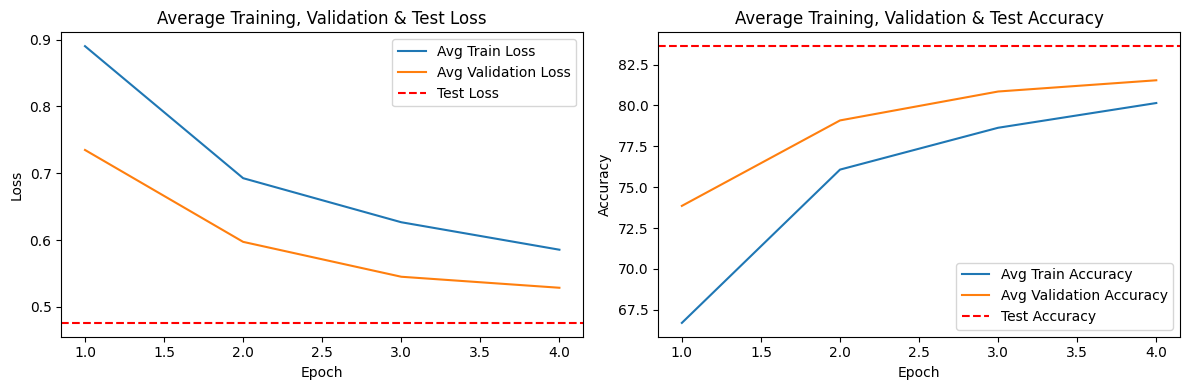

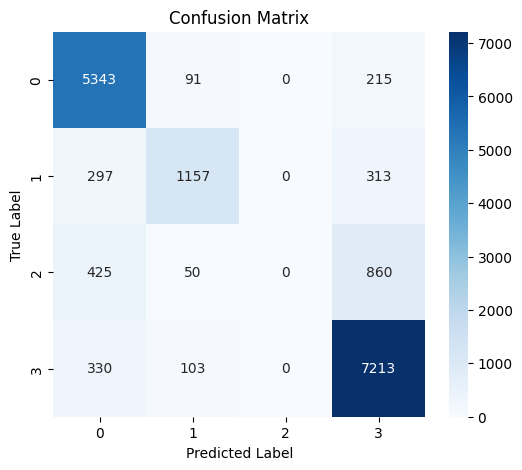

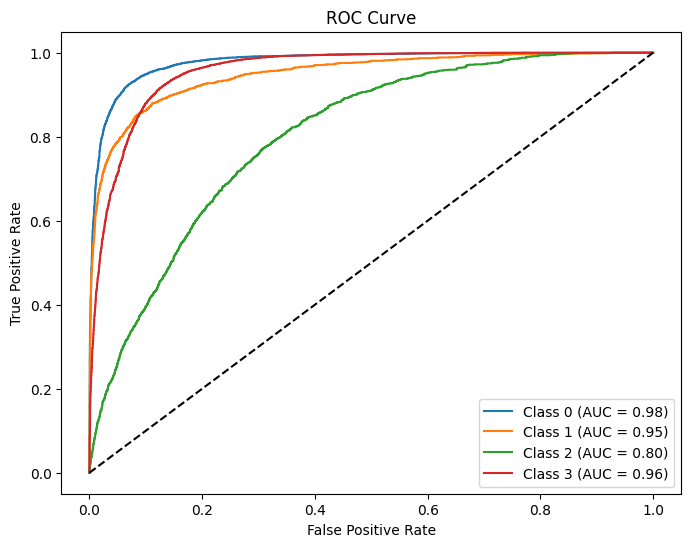

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Avg Train Loss')
plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Avg Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Average Training, Validation & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_train_accuracies) + 1), avg_train_accuracies, label='Avg Train Accuracy')
plt.plot(range(1, len(avg_val_accuracies) + 1), avg_val_accuracies, label='Avg Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Average Training, Validation & Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plot_confusion_matrix(cm, classes=np.unique(all_labels), title='Confusion Matrix')

num_classes = all_probs.shape[1]
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


__LOSS MODEL EARLY STOPING__

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        focal_weight = (1 - target_probs) ** self.gamma
        focal_loss = -focal_weight * log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            alpha_factor = self.alpha[targets]
            focal_loss *= alpha_factor

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN().to(device)

loss_function = FocalLoss(gamma=2, alpha=None, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'loss_model_weights_early_stopping.pth'


In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load(best_model_path))


Epoch 1/5, Train Loss: 0.5068, Train Accuracy: 61.75%, Val Loss: 0.3512, Val Accuracy: 75.98%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.3492, Train Accuracy: 76.02%, Val Loss: 0.2885, Val Accuracy: 79.29%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.3068, Train Accuracy: 78.41%, Val Loss: 0.2540, Val Accuracy: 80.84%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.2811, Train Accuracy: 79.80%, Val Loss: 0.2269, Val Accuracy: 82.62%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.2543, Train Accuracy: 81.28%, Val Loss: 0.2175, Val Accuracy: 83.35%
Best model weights saved at epoch 5


<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []
all_predictions_prob = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        all_predictions_prob.extend(F.softmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.2f}%")

Test Loss : 0.2150
Test Accuracy : 83.46%


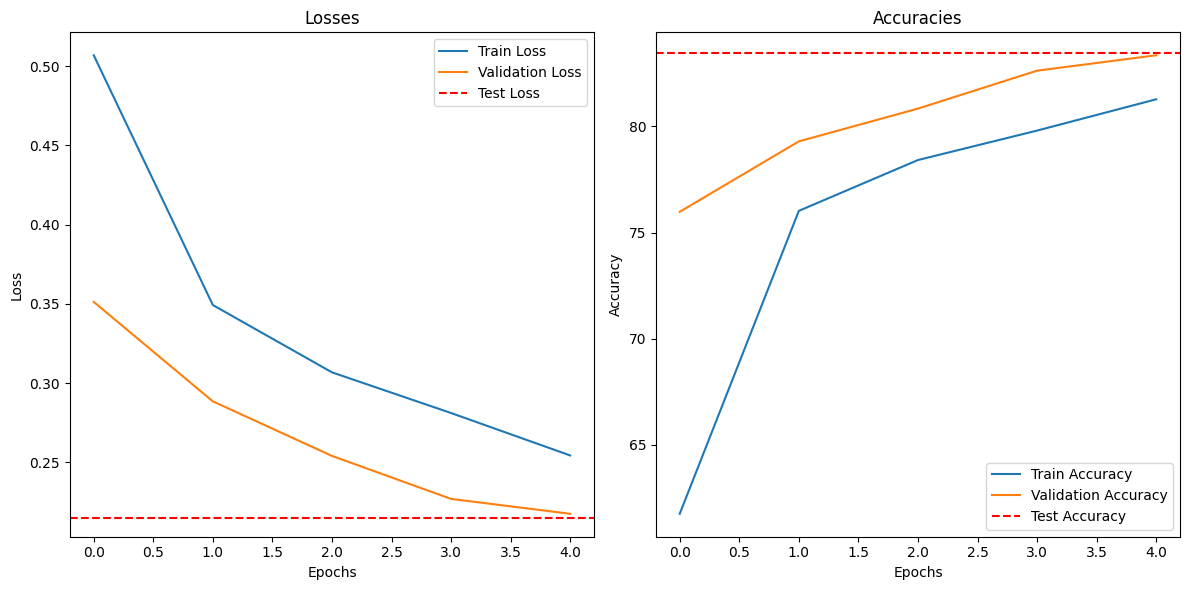

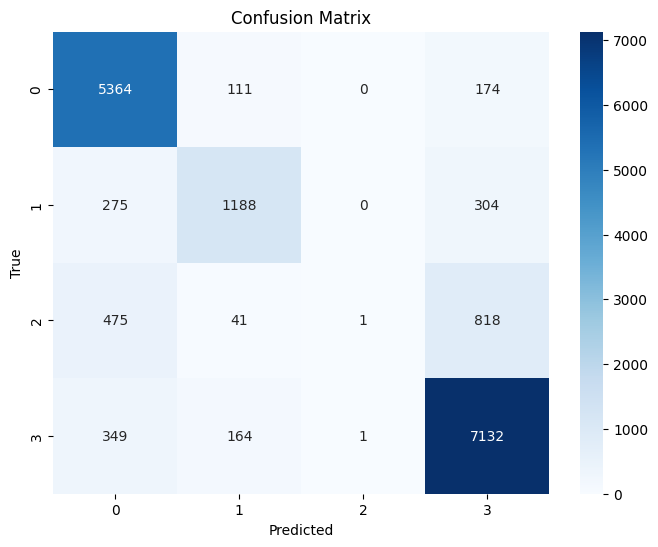

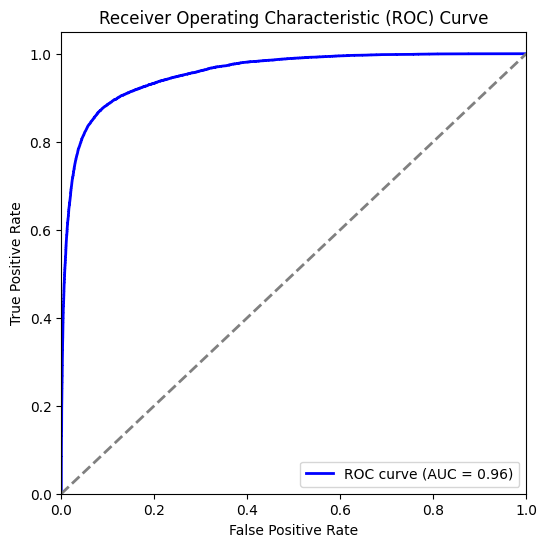

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

true_labels_bin = LabelBinarizer().fit_transform(all_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


__LOSS MODEL LEARNING RATE SCHEDULER__

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_model_path = 'loss_model_weights_learning_rate.pth'

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded the best model weights for evaluation.")
else:
    print("No saved weights found, starting with a fresh model.")

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

No saved weights found, starting with a fresh model.
Epoch 1/5, Train Loss: 0.8824, Train Accuracy: 67.00%, Val Loss: 0.6974, Val Accuracy: 74.95%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.6953, Train Accuracy: 75.90%, Val Loss: 0.5808, Val Accuracy: 79.93%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.6188, Train Accuracy: 78.82%, Val Loss: 0.5475, Val Accuracy: 80.84%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.5814, Train Accuracy: 80.20%, Val Loss: 0.4870, Val Accuracy: 83.17%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.5560, Train Accuracy: 81.17%, Val Loss: 0.5173, Val Accuracy: 81.58%


In [ ]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss (Using Best Weights): {test_loss:.4f}")
print(f"Test Accuracy (Using Best Weights): {test_accuracy:.2f}%")

Test Loss (Using Best Weights): 0.5160
Test Accuracy (Using Best Weights): 81.72%


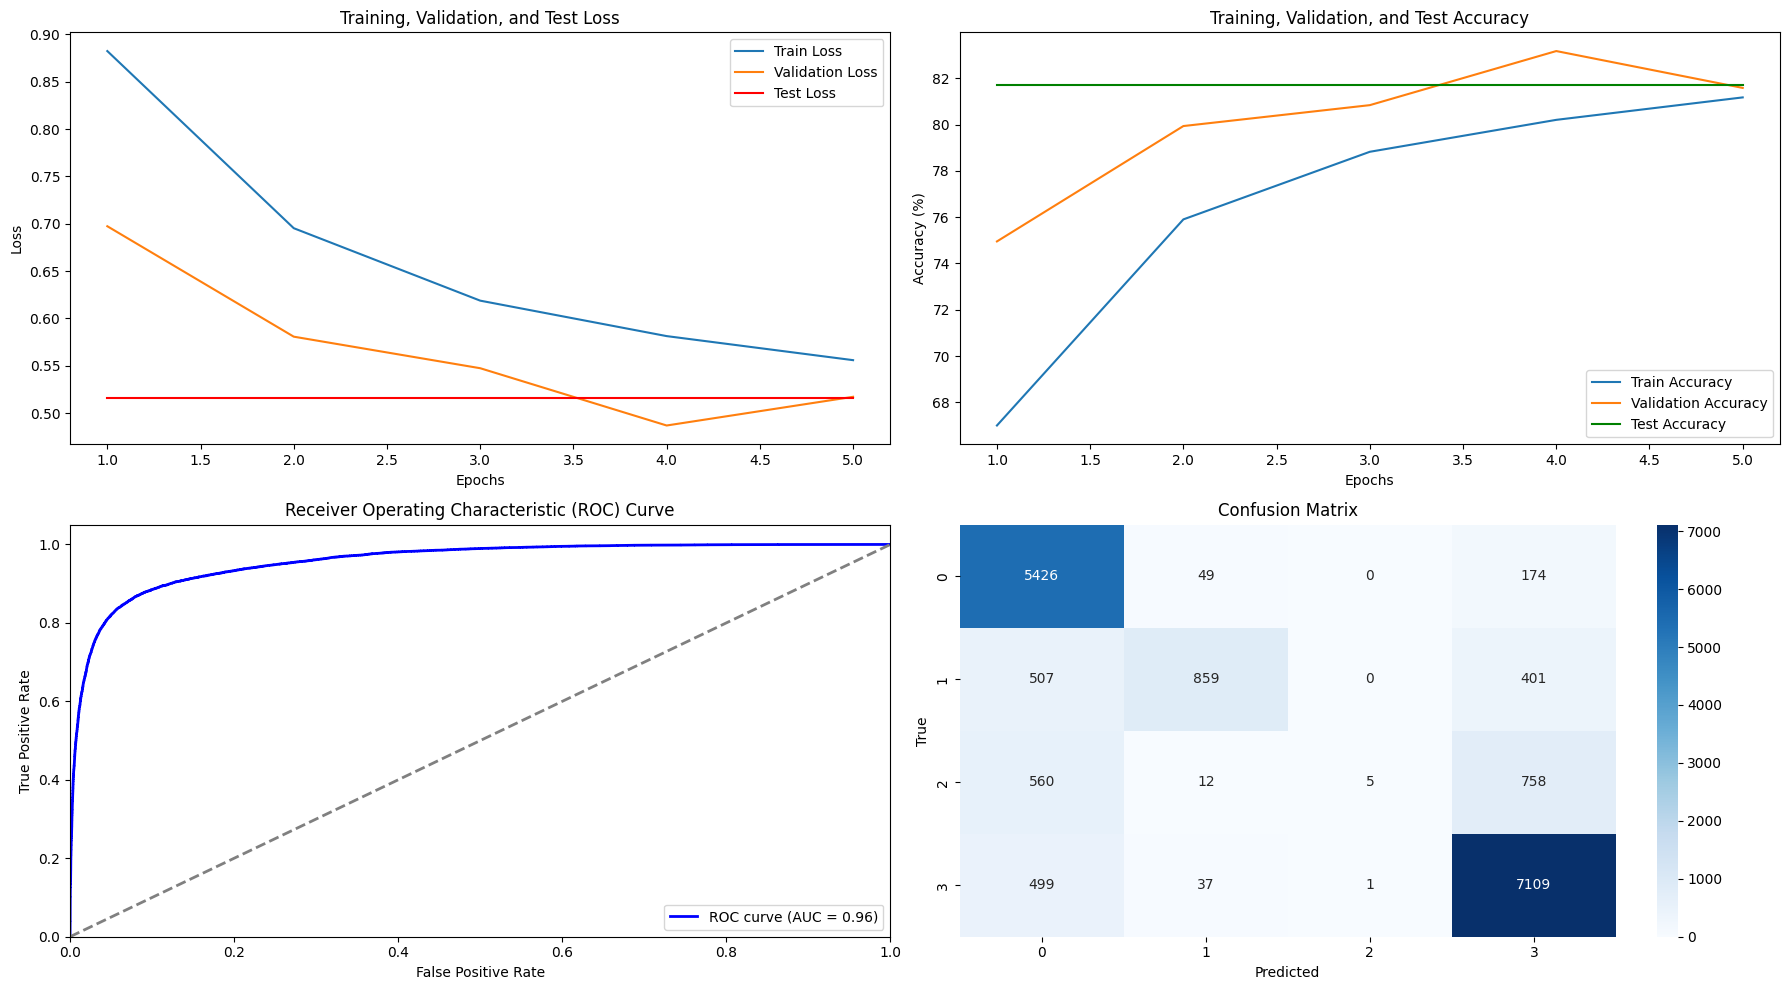

In [ ]:
plt.figure(figsize=(18, 10))

test_loss_values = [test_loss] * epochs
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs + 1), test_loss_values, label='Test Loss', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

test_accuracy_values = [test_accuracy] * epochs
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

true_labels_bin = LabelBinarizer().fit_transform(all_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

cm = confusion_matrix(all_labels, all_predictions)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

__LOSS MODEL BATCH NORMALIZATION__

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=4):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()
    
class SimplerOCTMNIST_CNN_BN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN_BN().to(device)

loss_function = FocalLoss(alpha=0.25, gamma=2, num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'loss_model_weights_batch_normalization.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.0924, Train Accuracy: 74.27%, Val Loss: 0.3616, Val Accuracy: 37.63%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.0702, Train Accuracy: 80.00%, Val Loss: 0.0675, Val Accuracy: 81.03%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.0658, Train Accuracy: 80.89%, Val Loss: 0.0739, Val Accuracy: 79.57%
Epoch 4/5, Train Loss: 0.0614, Train Accuracy: 81.79%, Val Loss: 0.0894, Val Accuracy: 77.32%
Epoch 5/5, Train Loss: 0.0581, Train Accuracy: 82.63%, Val Loss: 0.0631, Val Accuracy: 81.15%
Best model weights saved at epoch 5


In [ ]:
model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss (using best weights): {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Loaded the best model weights for evaluation.
Test Loss (using best weights): 0.0637, Test Accuracy: 81.14%


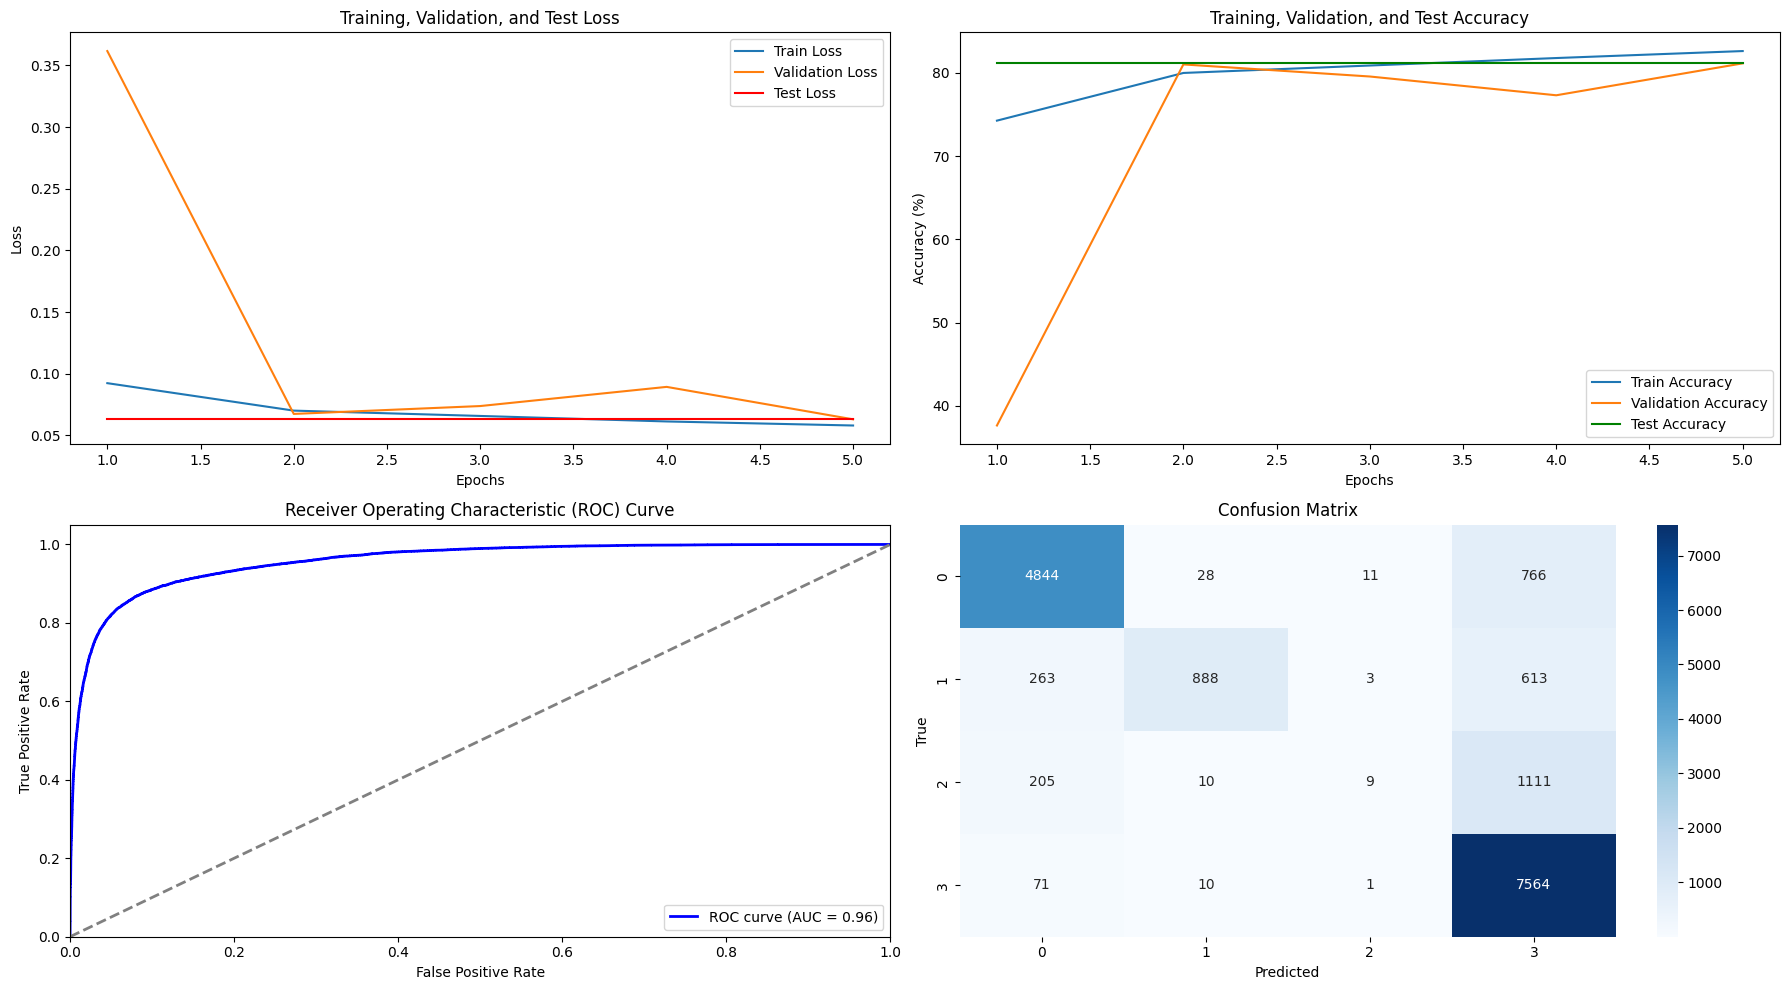

In [ ]:
plt.figure(figsize=(18, 10))

test_loss_values = [test_loss] * epochs
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs + 1), test_loss_values, label='Test Loss', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

test_accuracy_values = [test_accuracy] * epochs
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_values, label='Test Accuracy', color='green')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

true_labels_bin = LabelBinarizer().fit_transform(all_labels)
predictions_prob = np.array(all_predictions_prob)

if true_labels_bin.shape[0] != predictions_prob.shape[0]:
    print(f"Shape mismatch: true_labels_bin has {true_labels_bin.shape[0]} samples, "
          f"predictions_prob has {predictions_prob.shape[0]} samples")

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

cm = confusion_matrix(all_labels, all_predictions)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

__LOSS MODEL K-FOLD CROSS-VALIDATION__

In [ ]:
from sklearn.model_selection import KFold

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, num_classes=4):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)

        targets = F.one_hot(targets, num_classes=self.num_classes).float()

        pt = torch.sum(inputs * targets, dim=1)
        loss = -self.alpha * (1 - pt) ** self.gamma * torch.log(pt + 1e-8)

        return torch.mean(loss)

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_function = FocalLoss(gamma=2, alpha=0.25, num_classes=4)

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

k_folds = 4
kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}
best_val_loss = float('inf')
best_model_path = 'loss_model_weights_k_fold.pth'

for fold, (train_ids, val_ids) in enumerate(kfold.split(combined_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(combined_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = DataLoader(combined_dataset, batch_size=64, sampler=val_subsampler)

    model = SimplerOCTMNIST_CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    epochs = 4
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.squeeze().long()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model weights saved at fold {fold}, epoch {epoch+1}")

    results[fold] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

avg_train_losses = np.mean([results[fold]['train_losses'] for fold in range(k_folds)], axis=0)
avg_val_losses = np.mean([results[fold]['val_losses'] for fold in range(k_folds)], axis=0)
avg_train_accuracies = np.mean([results[fold]['train_accuracies'] for fold in range(k_folds)], axis=0)
avg_val_accuracies = np.mean([results[fold]['val_accuracies'] for fold in range(k_folds)], axis=0)

cuda
FOLD 0
--------------------------------
Epoch 1/4, Train Loss: 0.1403, Train Accuracy: 55.18%, Val Loss: 0.0972, Val Accuracy: 73.08%
Best model weights saved at fold 0, epoch 1
Epoch 2/4, Train Loss: 0.1010, Train Accuracy: 72.47%, Val Loss: 0.0842, Val Accuracy: 75.34%
Best model weights saved at fold 0, epoch 2
Epoch 3/4, Train Loss: 0.0913, Train Accuracy: 74.34%, Val Loss: 0.0792, Val Accuracy: 76.77%
Best model weights saved at fold 0, epoch 3
Epoch 4/4, Train Loss: 0.0844, Train Accuracy: 76.20%, Val Loss: 0.0686, Val Accuracy: 79.41%
Best model weights saved at fold 0, epoch 4
FOLD 1
--------------------------------
Epoch 1/4, Train Loss: 0.1414, Train Accuracy: 54.33%, Val Loss: 0.0949, Val Accuracy: 73.63%
Epoch 2/4, Train Loss: 0.0972, Train Accuracy: 73.99%, Val Loss: 0.0809, Val Accuracy: 77.48%
Epoch 3/4, Train Loss: 0.0858, Train Accuracy: 76.66%, Val Loss: 0.0696, Val Accuracy: 80.17%
Epoch 4/4, Train Loss: 0.0761, Train Accuracy: 78.70%, Val Loss: 0.0616, Val Accu

In [ ]:
model = SimplerOCTMNIST_CNN().to(device)
model.load_state_dict(torch.load(best_model_path))
print("Loaded the best model weights for evaluation.")

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []
all_probs = [] 

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss (using best weights): {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Loaded the best model weights for evaluation.
Test Loss (using best weights): 0.0611, Test Accuracy: 82.30%


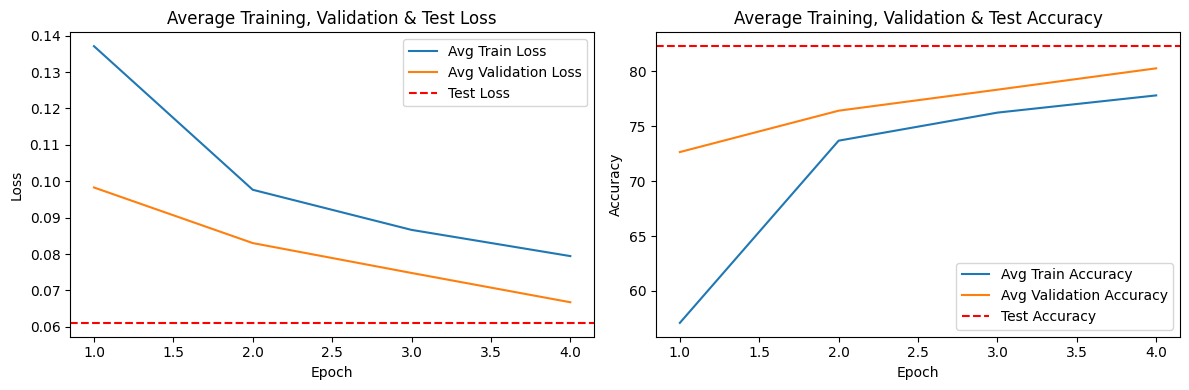

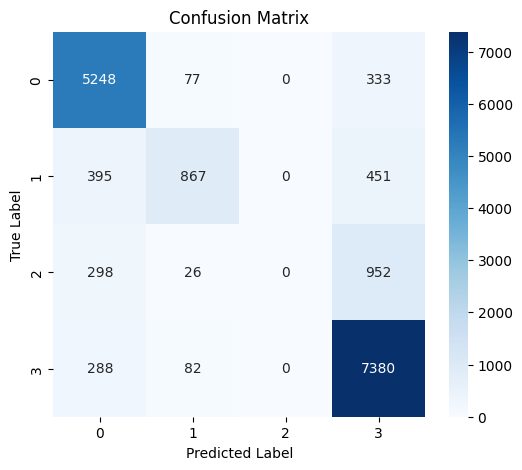

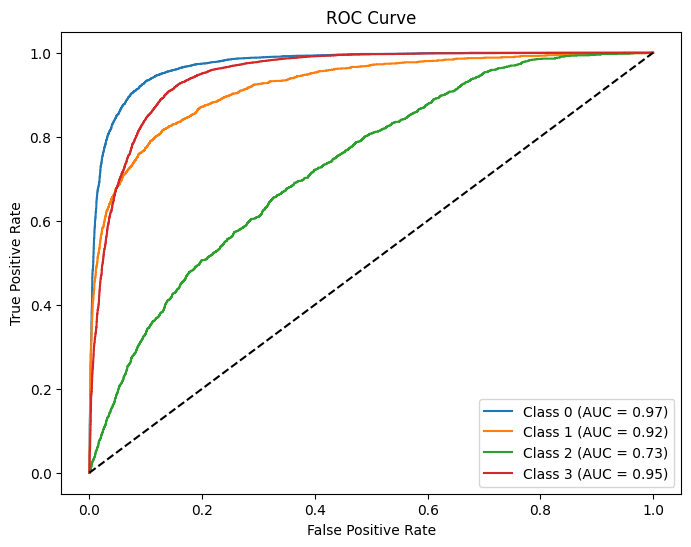

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Avg Train Loss')
plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Avg Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Test Loss Line
plt.title('Average Training, Validation & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_train_accuracies) + 1), avg_train_accuracies, label='Avg Train Accuracy')
plt.plot(range(1, len(avg_val_accuracies) + 1), avg_val_accuracies, label='Avg Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Test Accuracy Line
plt.title('Average Training, Validation & Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plot_confusion_matrix(cm, classes=np.unique(all_labels), title='Confusion Matrix')

num_classes = all_probs.shape[1]
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

__BEST MOEL LEARNING RATE SCHEDULER__

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimplerOCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(SimplerOCTMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplerOCTMNIST_CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'a0_part_3_pgnanase.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model weights saved at epoch {epoch+1}")

Epoch 1/5, Train Loss: 0.8922, Train Accuracy: 66.73%, Val Loss: 0.6692, Val Accuracy: 76.33%
Best model weights saved at epoch 1
Epoch 2/5, Train Loss: 0.6789, Train Accuracy: 76.86%, Val Loss: 0.5591, Val Accuracy: 80.64%
Best model weights saved at epoch 2
Epoch 3/5, Train Loss: 0.6002, Train Accuracy: 79.63%, Val Loss: 0.5124, Val Accuracy: 82.31%
Best model weights saved at epoch 3
Epoch 4/5, Train Loss: 0.5438, Train Accuracy: 81.84%, Val Loss: 0.4619, Val Accuracy: 84.06%
Best model weights saved at epoch 4
Epoch 5/5, Train Loss: 0.5171, Train Accuracy: 82.45%, Val Loss: 0.4431, Val Accuracy: 84.23%
Best model weights saved at epoch 5


In [ ]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.2f}%")

Test Loss : 0.4571
Test Accuracy : 84.11%


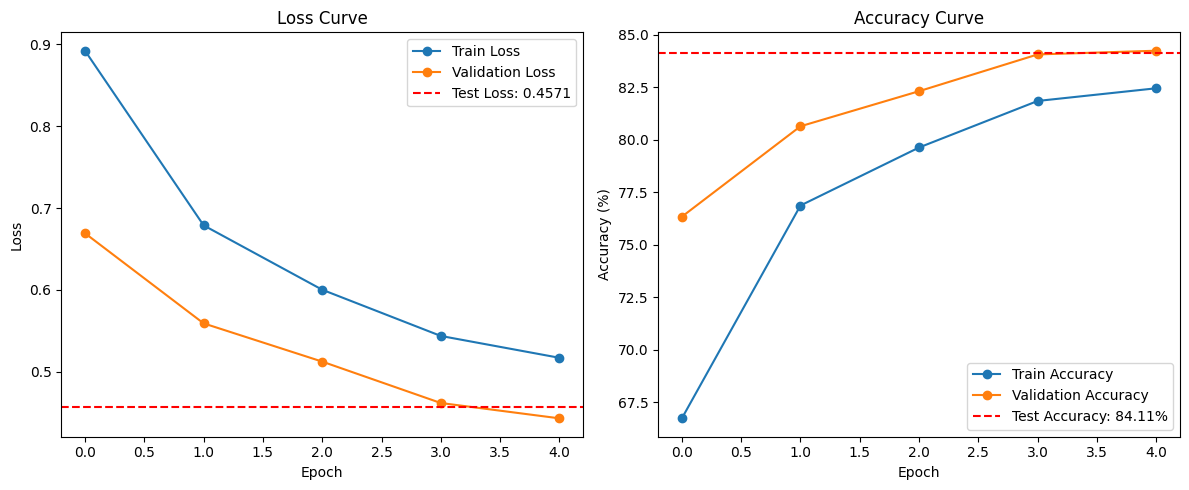

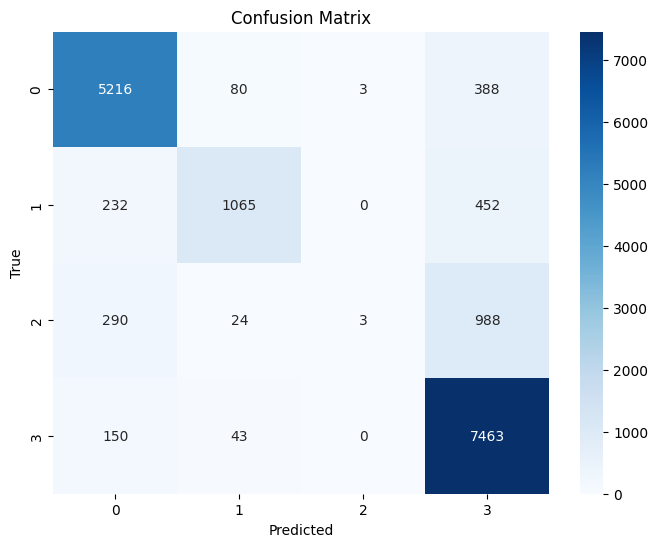

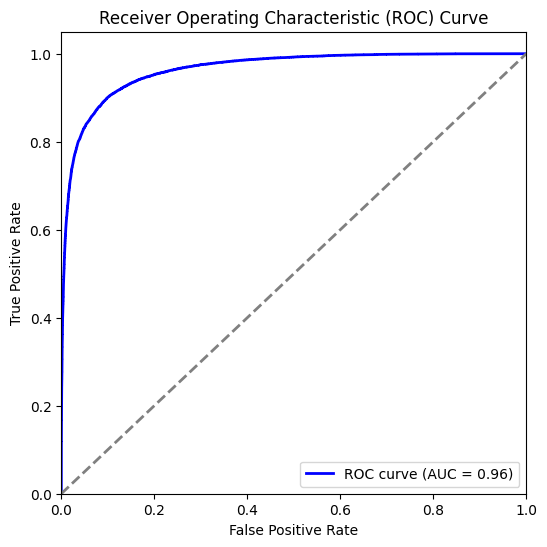

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}%')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

all_predictions_prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        all_predictions_prob.extend(probabilities.cpu().numpy())

true_labels_bin = LabelBinarizer().fit_transform(all_labels)
predictions_prob = np.array(all_predictions_prob)

fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predictions_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()